# Importing Jupyter Notebooks as Modules

It is a common problem that people want to import code from Jupyter Notebooks.
This is made difficult by the fact that Notebooks are not plain Python files,
and thus cannot be imported by the regular Python machinery.

Fortunately, Python provides some fairly sophisticated [hooks](http://www.python.org/dev/peps/pep-0302/) into the import machinery,
so we can actually make Jupyter notebooks importable without much difficulty,
and only using public APIs.

In [1]:
import io, os, sys, types

In [2]:
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

Import hooks typically take the form of two objects:

1. a Module **Loader**, which takes a module name (e.g. `'IPython.display'`), and returns a Module
2. a Module **Finder**, which figures out whether a module might exist, and tells Python what **Loader** to use

In [3]:
def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path
    
    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path
            

## Notebook Loader

Here we have our Notebook Loader.
It's actually quite simple - once we figure out the filename of the module,
all it does is:

1. load the notebook document into memory
2. create an empty Module
3. execute every cell in the Module namespace

Since IPython cells can have extended syntax,
the IPython transform is applied to turn each of these cells into their pure-Python counterparts before executing them.
If all of your notebook cells are pure-Python,
this step is unnecessary.

In [4]:
class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path
    
    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)
        
        print ("importing Jupyter notebook from %s" % path)
                                       
        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)
        
        
        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod
        
        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__
        
        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod


## The Module Finder

The finder is a simple object that tells you whether a name can be imported,
and returns the appropriate loader.
All this one does is check, when you do:

```python
import mynotebook
```

it checks whether `mynotebook.ipynb` exists.
If a notebook is found, then it returns a NotebookLoader.

Any extra logic is just for resolving paths within packages.

In [5]:
class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}
    
    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return
        
        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)
        
        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]


## Register the hook

Now we register the `NotebookFinder` with `sys.meta_path`

In [6]:
sys.meta_path.append(NotebookFinder())

In [8]:
ls

Importing Notebooks.ipynb  linear_algebra.ipynb  visualizing_data.ipynb
__init__.py                README.md
LICENSE                    statistics.ipynb


importing Jupyter notebook from linear_algebra.ipynb


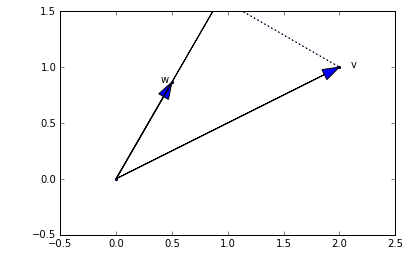

In [9]:
from linear_algebra import sum_of_squares, dot

After this point, my notebooks should be importable.

Let's look at what we have in the CWD:

In [7]:
#ls nbpackage

ls: impossible d'accéder à 'nbpackage': Aucun fichier ou dossier de ce type


So I should be able to `import nbpackage.mynotebook`.

In [ ]:
#import nbpackage.mynotebook

### Aside: displaying notebooks

Here is some simple code to display the contents of a notebook
with syntax highlighting, etc.

In [ ]:
from pygments import highlight
from pygments.lexers import PythonLexer
from pygments.formatters import HtmlFormatter

from IPython.display import display, HTML

formatter = HtmlFormatter()
lexer = PythonLexer()

# publish the CSS for pygments highlighting
display(HTML("""
<style type='text/css'>
%s
</style>
""" % formatter.get_style_defs()
))

In [ ]:
def show_notebook(fname):
    """display a short summary of the cells of a notebook"""
    with io.open(fname, 'r', encoding='utf-8') as f:
        nb = read(f, 4)
    html = []
    for cell in nb.cells:
        html.append("<h4>%s cell</h4>" % cell.cell_type)
        if cell.cell_type == 'code':
            html.append(highlight(cell.source, lexer, formatter))
        else:
            html.append("<pre>%s</pre>" % cell.source)
    display(HTML('\n'.join(html)))

show_notebook(os.path.join("nbpackage", "mynotebook.ipynb"))

So my notebook has a heading cell and some code cells,
one of which contains some IPython syntax.

Let's see what happens when we import it

In [ ]:
from nbpackage import mynotebook

Hooray, it imported!  Does it work?

In [ ]:
mynotebook.foo()

Hooray again!

Even the function that contains IPython syntax works:

In [ ]:
mynotebook.has_ip_syntax()

## Notebooks in packages

We also have a notebook inside the `nb` package,
so let's make sure that works as well.

In [ ]:
ls nbpackage/nbs

Note that the `__init__.py` is necessary for `nb` to be considered a package,
just like usual.

In [ ]:
show_notebook(os.path.join("nbpackage", "nbs", "other.ipynb"))

In [ ]:
from nbpackage.nbs import other
other.bar(5)

So now we have importable notebooks, from both the local directory and inside packages.

I can even put a notebook inside IPython, to further demonstrate that this is working properly:

In [ ]:
import shutil
from IPython.paths import get_ipython_package_dir

utils = os.path.join(get_ipython_package_dir(), 'utils')
shutil.copy(os.path.join("nbpackage", "mynotebook.ipynb"),
            os.path.join(utils, "inside_ipython.ipynb")
)

and import the notebook from `IPython.utils`

In [ ]:
from IPython.utils import inside_ipython
inside_ipython.whatsmyname()

This approach can even import functions and classes that are defined in a notebook using the `%%cython` magic.